### Spatial Optimization (1): p-Median  Problem

This problem entails the location of p-facilities while minimizing the total weighted distance of servicing all demands. 
Each node has an associated weight that represents the amount of demand at that node.


**Objective function:** Minimizing demand-weighted  summed over all facilities and demand nodes.

**Decision variables:** where to put the facilities and which demand nodes are serviced by which facility location 

**Constraints:**
- Each node is serviced by 1 facility
- A node can be serviced by a facility at a certain location only if there is a facility.
- We must place p facilities
- Each node is either a facility or not. 

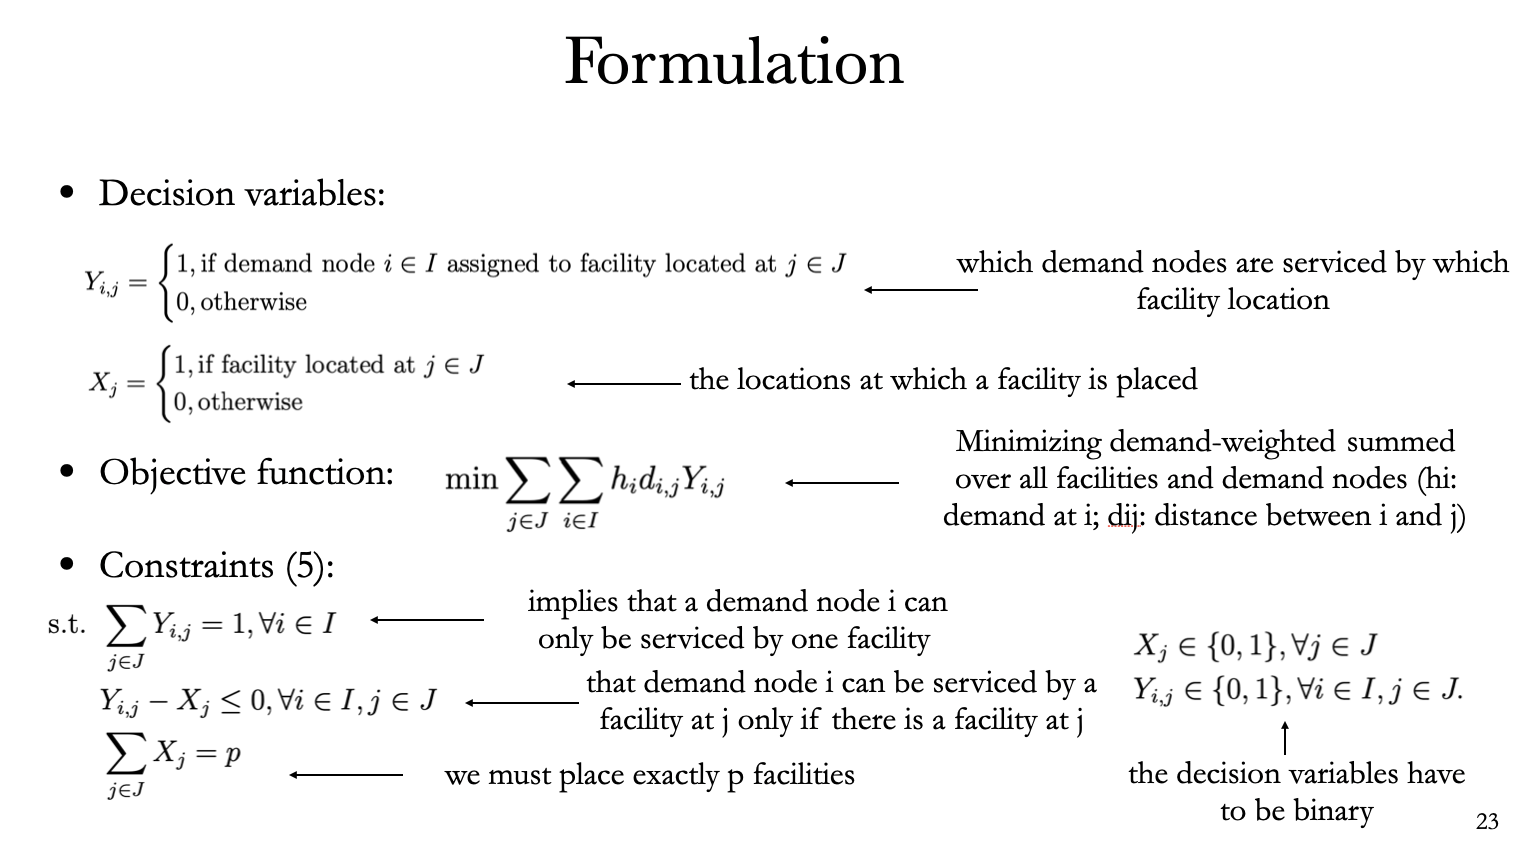

In [1]:
from pulp import *
import numpy as np
import geopandas as gp
from scipy.spatial.distance import cdist

import libpysal as ps
import matplotlib.pyplot as plt

In [5]:
#read a sample shapefile
georgia_shp = gp.read_file("georgia.shp") 

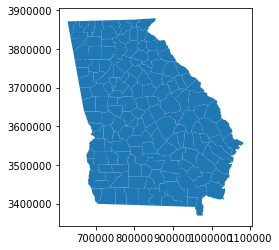

In [13]:
georgia_shp.plot()

In [8]:
#create a demand and a facilities variable, indicating the indices of each demand and facility.
#demand node: all counties
#facility: we could build facilities in some counties

demand = np.arange(0,159,1)
facilities = np.arange(0,159,1)


In [14]:
#Calculate a distance matrix d_ij (n by n)
coords = list(zip(georgia_shp.centroid.x,georgia_shp.centroid.y))

d = cdist(coords,coords) 

In [18]:
d

array([[     0.        ,  75374.03018149,  26725.31558187, ...,
        229820.70518888, 143561.70946236, 149947.1940643 ],
       [ 75374.03018149,      0.        ,  49665.82754924, ...,
        276234.95619942, 169333.24491334,  96587.09508367],
       [ 26725.31558187,  49665.82754924,      0.        , ...,
        249042.18043074, 154391.43849134, 132915.00612261],
       ...,
       [229820.70518888, 276234.95619942, 249042.18043074, ...,
             0.        , 115905.74156027, 268586.73973539],
       [143561.70946236, 169333.24491334, 154391.43849134, ...,
        115905.74156027,      0.        , 152932.37329811],
       [149947.1940643 ,  96587.09508367, 132915.00612261, ...,
        268586.73973539, 152932.37329811,      0.        ]])

In [22]:
#the demand for each county (h_i) is the total populatoion 
h = georgia_shp.TotPop90.values

In [25]:
# declare facilities variables
X = LpVariable.dicts('X_%s',(facilities),cat='Binary')

# declare demand-facility pair variables
Y = LpVariable.dicts('Y_%s_%s', (demand,facilities),cat='Binary') 

In [40]:
#Number of facilities to place
p = 1 #change this and re-run the code.

prob = LpProblem('P_Median_GA', LpMinimize)

In [41]:
# Objective function: Minimizing demand-distance weighted summed over all facilities and demand nodes 
# (h_i: demand at i; d_ij: distance between i and j)

prob += sum(sum(h[i] * d[i][j] * Y[i][j] for j in facilities) for i in demand)

In [42]:
# This constraint indicates we must place exactly p facilities

prob += sum([X[j] for j in facilities]) == p

In [43]:
# This constraint implies that a demand node i can only be serviced by one facility

for i in demand: 
    prob += sum(Y[i][j] for j in facilities) == 1
    

In [44]:
# This constraint implies that that demand node i 
# can be serviced by a facility at j only if there is a facility at j

# It implicitly removes situation when X[j] = 0 but Y[i][j] = 1 
# (node i is served by j but there is no facility at j)

for i in demand:
    for j in facilities: 
        prob +=  Y[i][j] <= X[j]

In [45]:
%%time
# Solve the above problem
prob.solve()

print("Status:", LpStatus[prob.status])

Status: Optimal
CPU times: user 870 ms, sys: 59.8 ms, total: 930 ms
Wall time: 5 s


In [46]:
# The minimized total demand-distance. The unit is person * meter
print("Objective: ",value(prob.objective))

Objective:  786919423745.2424


In [47]:
# Print the facility node.
rslt=[]
for v in prob.variables():
    subV = v.name.split('_')
    
    if subV[0] == "X" and v.varValue == 1: 
        rslt.append(int(subV[1]))
        print('Facility Node: ', subV[1])

Facility Node:  43


In [48]:
rslt

[43]

In [54]:
# Get the geomerty of the facility nodes.
fac_loc = georgia_shp.iloc[rslt,:]

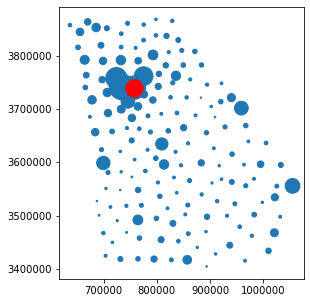

In [55]:
#Plot the faclities (stars) on top of the demand map.
fig, ax = plt.subplots(figsize=(5,5))

georgia_shp.centroid.plot(ax=ax,markersize=georgia_shp.TotPop90/1000)#markersize is proportional to the population

fac_loc.centroid.plot(ax=ax,color="red",markersize=300)